# Anaylsis Bike Sharing Data

In [4]:
import numpy as np
import pandas as pd
import datetime
import matplotlib as plt
%matplotlib inline
from sqlalchemy import create_engine
import requests
import time

import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin
import geoplot

# Analysis

In [12]:
df = pd.read_csv('../../data/cleaned.csv', parse_dates=['timestamp','end_timestamp', 'duration'])

In [13]:
df.head()

,id,id.1,bikeId,providerId,timestamp,latitude,longitude,prev_id,next_id,prev_lat,...,next_lon,end_timestamp,mode,response,geometry,distance,calc_time,waypoints,duration,speed
0,1,1,13001,0,2019-04-05 08:20:04.689917,52.510327,13.405788,13001.0,13001.0,52.536506,...,13.405788,2019-04-05 13:44:04.154419,accessible,NaN,NaN,NaN,NaN,NaN,0 days 05:23:59.464502000,NaN
1,2,2,13001,0,2019-04-05 13:44:04.154419,52.510327,13.405788,13001.0,13001.0,52.510327,...,13.421259,2019-04-05 18:16:03.582939,trip,{'routes': [{'geometry': {'coordinates': [[13....,"{'coordinates': [[13.405853, 52.510328], [13.4...",3238.3,939.0,"[{'name': 'Neue Grünstraße', 'hint': 'OmIBgK6Q...",0 days 04:31:59.428520000,0.714356
2,3,3,13001,0,2019-04-05 18:16:03.582939,52.532190,13.421259,13001.0,13001.0,52.510327,...,13.421259,2019-04-05 18:20:04.351730,accessible,NaN,NaN,NaN,NaN,NaN,0 days 00:04:00.768791000,NaN
3,4,4,13001,0,2019-04-05 18:20:04.351730,52.532190,13.421259,13001.0,13001.0,52.532190,...,13.421317,2019-04-05 18:24:03.220242,accessible,NaN,NaN,NaN,NaN,NaN,0 days 00:03:58.868512000,NaN
4,5,5,13001,0,2019-04-05 18:24:03.220242,52.532183,13.421317,13001.0,13001.0,52.532190,...,13.421317,2019-04-06 12:48:04.815239,accessible,NaN,NaN,NaN,NaN,NaN,0 days 18:24:01.594997000,NaN


In [15]:
df.duration = df.end_timestamp - df.timestamp

In [253]:
# day of the year
df['yday'] = df.timestamp.apply(lambda x: x.timetuple().tm_yday)

# hour of the day
df['dhour'] = df.timestamp.apply(lambda x: x.time().hour)

# "hour of the year"
df['yhour'] = df.timestamp.apply(lambda x: str(x.time().hour) + str(x.timetuple().tm_yday))

# day of week
df['dweek'] = df.timestamp.apply(lambda x: x.weekday())

In [16]:
df.describe()

,id,id.1,bikeId,providerId,latitude,longitude,prev_id,next_id,prev_lat,prev_lon,next_lat,next_lon,distance,calc_time,duration,speed
count,3.626252e+06,3.626252e+06,3.626252e+06,3.626252e+06,3.626252e+06,3.626252e+06,3.626252e+06,3.626252e+06,3.626252e+06,3.626252e+06,3.626252e+06,3.626252e+06,661064.000000,661064.000000,3626252,661064.000000
mean,2.440943e+06,2.440943e+06,6.123823e+08,1.679179e+00,5.250986e+01,1.338660e+01,6.123821e+08,6.123823e+08,5.250986e+01,1.338672e+01,5.250985e+01,1.338661e+01,2041.843521,612.488476,0 days 04:10:38.520627,4.711225
std,1.463192e+06,1.463192e+06,3.509698e+08,6.040748e-01,2.151929e-02,4.751760e-02,3.509699e+08,3.509698e+08,3.071263e-02,1.346206e-01,2.152272e-02,4.754076e-02,2067.833651,572.172023,0 days 10:47:34.954197,5.547541
min,1.000000e+00,1.000000e+00,1.300100e+04,0.000000e+00,5.233902e+01,1.301072e+01,1.300100e+04,1.300100e+04,2.248054e+01,-1.344200e+02,5.233902e+01,1.301072e+01,100.100000,16.900000,0 days 00:00:06.225870,0.004344
25%,1.121774e+06,1.121774e+06,8.100001e+08,2.000000e+00,5.249344e+01,1.334914e+01,8.100001e+08,8.100001e+08,5.249337e+01,1.334957e+01,5.249342e+01,1.334915e+01,349.800000,153.300000,0 days 00:27:58.510768,0.526149
50%,2.425638e+06,2.425638e+06,8.100236e+08,2.000000e+00,5.250907e+01,1.338850e+01,8.100236e+08,8.100236e+08,5.250911e+01,1.338901e+01,5.250905e+01,1.338850e+01,1432.700000,445.300000,0 days 02:28:00.087468,2.731577
75%,3.714876e+06,3.714876e+06,8.160356e+08,2.000000e+00,5.252607e+01,1.342509e+01,8.160356e+08,8.160356e+08,5.252615e+01,1.342520e+01,5.252606e+01,1.342513e+01,3018.700000,893.100000,0 days 03:47:59.027103,7.240797
max,5.000216e+06,5.000216e+06,8.160550e+08,2.000000e+00,5.268865e+01,1.378699e+01,8.160550e+08,8.160550e+08,5.830499e+01,1.631155e+01,5.268865e+01,1.378699e+01,34504.700000,9376.200000,93 days 21:35:59.111435,29.999916


In [17]:
df['mode'].value_counts()

accessible    2965188
trip           661064
Name: mode, dtype: int64

In [18]:
df.groupby('providerId').distance.describe()

,count,mean,std,min,25%,50%,75%,max
providerId,,,,,,,,
0,101215.0,3028.931747,2337.679531,100.1,1327.65,2507.6,4221.45,34504.7
1,211512.0,2539.926076,1986.279083,100.1,1060.30,2059.8,3588.20,18159.2
2,348337.0,1452.590665,1830.389019,100.1,196.00,646.0,1986.10,13909.0


In [291]:
trips = df[df['mode'] == 'trip']

In [25]:
trips.groupby('providerId').duration.describe()

,count,mean,std,min,25%,50%,75%,max
providerId,,,,,,,,
0,101215,0 days 03:17:01.500578,0 days 05:49:03.241760,0 days 00:02:52.188922,0 days 00:16:00.068861,0 days 00:31:35.060509,0 days 02:40:00.061074,0 days 23:59:59.988111
1,211512,0 days 00:47:05.558576,0 days 02:09:48.783779,0 days 00:02:34.203400,0 days 00:12:01.582322,0 days 00:20:00.140818,0 days 00:31:59.752732,0 days 23:59:59.885565
2,348337,0 days 02:34:14.975155,0 days 04:44:07.595819,0 days 00:02:43.350700,0 days 00:12:10.527099,0 days 00:32:00.361968,0 days 02:07:59.880636,0 days 23:59:59.973159


In [ ]:
# histogram of minutes spent on trip
df.duration.apply(lambda x: x.seconds / 60).hist(range=(0,250))

In [ ]:
# average duration of trips and accesible quases

In [27]:
df.loc[:,'hourly_starttime'] = df.timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 60)))

In [66]:
counts = trips[['bikeId', 'hourly_starttime']].groupby(['hourly_starttime']).count()

In [69]:
nb = trips[trips.providerId == 0][['bikeId', 'hourly_starttime']].groupby(['hourly_starttime']).count()

In [71]:
lb = trips[trips.providerId == 1][['bikeId', 'hourly_starttime']].groupby(['hourly_starttime']).count()

In [72]:
mb = trips[trips.providerId == 2][['bikeId', 'hourly_starttime']].groupby(['hourly_starttime']).count()

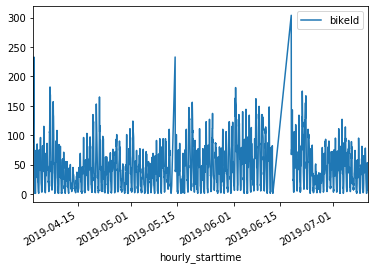

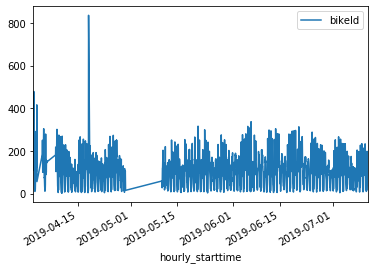

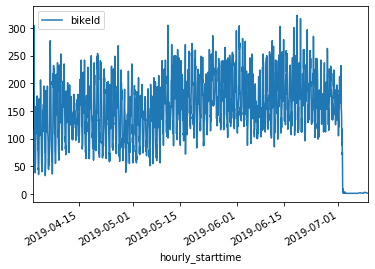

In [73]:
nb.plot()
lb.plot()
mb.plot()

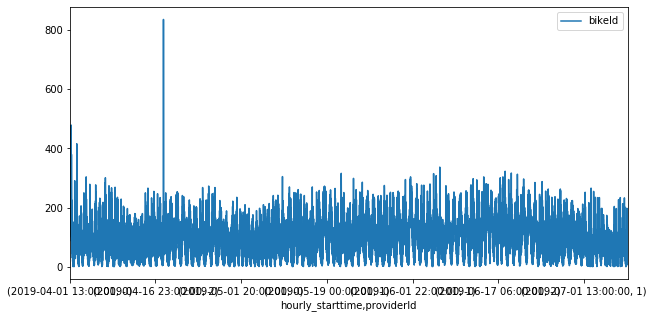

In [67]:
counts.plot(figsize=(10,5))

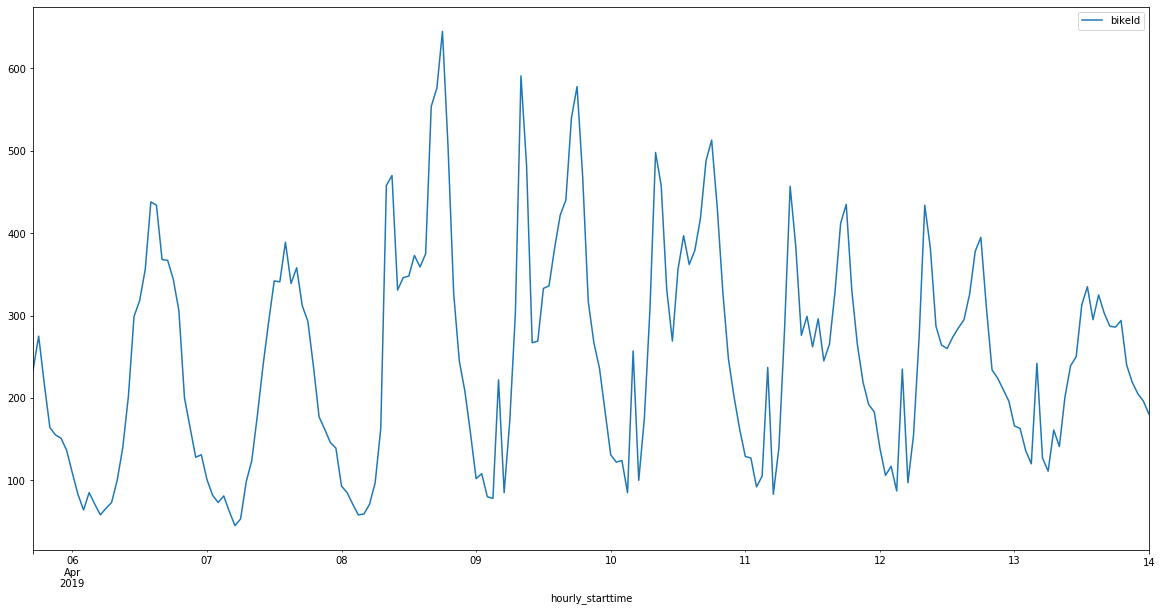

In [35]:
counts[100:300].plot(figsize=(20,10))

### original data

#### How many unique bike IDs are there (per provider)?

In [74]:
# how many bikes are available / on a trip for each hour?
def get_unique_ids_per_day(df):
    daily_unique = pd.DataFrame()

    start_time = df.sort_values('timestamp').reset_index().loc[0,'timestamp']
    end_time = df.sort_values('timestamp').reset_index().loc[df.shape[0]-2, 'timestamp']
    times= []
    
    # get all desired times
    while start_time < end_time:
        times.append(start_time)
        start_time += datetime.timedelta(hours=24)
    
    daily_unique['time'] = times
    daily_unique['total'] = daily_unique.time.apply(lambda x: df[
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    daily_unique['nextbike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 0)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    daily_unique['lidlbike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 1)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    daily_unique['mobike'] = daily_unique.time.apply(lambda x: df[
               (df.providerId == 2)&
               (df.timestamp <= x) & 
               (df.end_timestamp > x)].bikeId.unique().shape[0])
    
    return daily_unique
    

In [75]:
def get_unique_ids(df):
    unique_bikes = pd.DataFrame()
    unique_bikes = unique_bikes.append([([df.bikeId.unique().shape[0], df[(df.providerId == 0)].bikeId.unique().shape[0], 
             df[(df.providerId == 1)].bikeId.unique().shape[0],
             df[(df.providerId == 2)].bikeId.unique().shape[0]])])
    unique_bikes.columns = [['total', 'nextbike', 'lidlbike', 'mobike']]
    return unique_bikes

In [76]:
daily_uniques = get_unique_ids_per_day(df)

In [77]:
daily_uniques.describe()

,total,nextbike,lidlbike,mobike
count,102.000000,102.000000,102.000000,102.000000
mean,6200.647059,1054.480392,2343.431373,2802.735294
std,1435.069182,186.135303,926.606707,972.236545
min,265.000000,86.000000,95.000000,0.000000
25%,5523.000000,978.250000,2584.750000,3017.750000
50%,6904.500000,1063.500000,2731.000000,3130.000000
75%,7125.750000,1180.000000,2800.000000,3222.000000
max,7382.000000,1343.000000,2954.000000,3502.000000


In [386]:
uniques = get_unique_ids(df)
uniques

,total,nextbike,lidlbike,mobike
0,14546,2390,2816,9340


#### How much time is a bike used? 

In [87]:
# average trips per bike
trips.groupby(['bikeId', 'providerId']).count().id.groupby('providerId').describe()

,count,mean,std,min,25%,50%,75%,max
providerId,,,,,,,,
0,2365.0,42.797040,16.472283,1.0,33.0,43.0,53.0,191.0
1,3551.0,59.564066,26.760414,1.0,42.0,62.0,79.0,161.0
2,9186.0,37.920422,69.884386,1.0,17.0,30.0,45.0,1823.0


#### how high is the utilization rate? (available bikes / all bikes)

In [134]:
# all accessibe bikes each day
accessible = df.drop_duplicates(subset = ['yday', 'bikeId', 'providerId']).groupby(['yday', 'providerId']).count()

In [311]:
# all bikes in use each hour
in_use = trips[(trips.distance > 300)].groupby(['providerId', 'yday', 'yhour', 'dhour']).count()

In [312]:
# merge df on accessible bikes per day
in_use = in_use['id'].reset_index().set_index(['yday', 'providerId', 'dhour']).join(accessible['id.1'].reset_index().set_index(['yday', 'providerId']))
in_use.rename(columns={"id": "in_use", "id.1": "accessible"}, inplace=True)

In [313]:
usage_rate = (in_use.in_use / in_use.accessible).reset_index().groupby(['providerId', 'dhour']).median().reset_index()

In [316]:
usage_rate.describe()

,providerId,dhour,yday,0
count,72.000000,72.000000,72.000000,72.000000
mean,1.000000,11.500000,142.118056,0.035061
std,0.822226,6.970764,5.375671,0.023256
min,0.000000,0.000000,136.500000,0.003746
25%,0.000000,5.750000,137.500000,0.014830
50%,1.000000,11.500000,139.500000,0.030336
75%,2.000000,17.250000,149.000000,0.051557
max,2.000000,23.000000,150.500000,0.091234


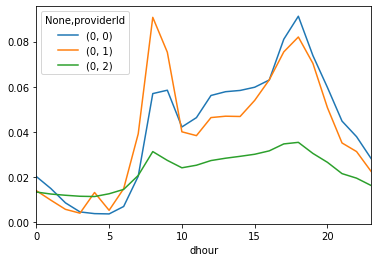

In [317]:
usage_rate.drop('yday', axis=1).set_index(['dhour','providerId']).unstack().plot()

Usage rate varies between 0 and 9 %.

#### how many bikes bikes are accessible / in use each day?

In [133]:
# on average accessible bikes per day
df.drop_duplicates(subset = ['yday', 'bikeId', 'providerId']).groupby(['yday', 'providerId']).count().groupby('providerId').median()

,id,id.1,bikeId,timestamp,latitude,longitude,prev_id,next_id,prev_lat,prev_lon,...,end_timestamp,mode,response,geometry,distance,calc_time,waypoints,duration,speed,hourly_starttime
providerId,,,,,,,,,,,,,,,,,,,,,
0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,...,953.0,953.0,378.0,378.0,378.0,378.0,378.0,953.0,378.0,953.0
1,2329.0,2329.0,2329.0,2329.0,2329.0,2329.0,2329.0,2329.0,2329.0,2329.0,...,2329.0,2329.0,656.5,656.5,656.5,656.5,656.5,2329.0,656.5,2329.0
2,4384.0,4384.0,4384.0,4384.0,4384.0,4384.0,4384.0,4384.0,4384.0,4384.0,...,4384.0,4384.0,340.0,340.0,340.0,340.0,340.0,4384.0,340.0,4384.0


In [138]:
# on overage used bikes per day
trips.drop_duplicates(subset = ['yday', 'bikeId', 'providerId']).groupby(['yday', 'providerId']).count().groupby('providerId').median()

,id,id.1,bikeId,timestamp,latitude,longitude,prev_id,next_id,prev_lat,prev_lon,...,end_timestamp,mode,response,geometry,distance,calc_time,waypoints,duration,speed,hourly_starttime
providerId,,,,,,,,,,,,,,,,,,,,,
0,618.0,618.0,618.0,618.0,618.0,618.0,618.0,618.0,618.0,618.0,...,618.0,618.0,618.0,618.0,618.0,618.0,618.0,618.0,618.0,618.0
1,1280.0,1280.0,1280.0,1280.0,1280.0,1280.0,1280.0,1280.0,1280.0,1280.0,...,1280.0,1280.0,1280.0,1280.0,1280.0,1280.0,1280.0,1280.0,1280.0,1280.0
2,1825.5,1825.5,1825.5,1825.5,1825.5,1825.5,1825.5,1825.5,1825.5,1825.5,...,1825.5,1825.5,1825.5,1825.5,1825.5,1825.5,1825.5,1825.5,1825.5,1825.5


In [146]:
# on overage used bikes per hour
df.groupby(['providerId', 'yhour']).count().groupby('providerId').median()

,id,id.1,bikeId,timestamp,latitude,longitude,prev_id,next_id,prev_lat,prev_lon,...,mode,response,geometry,distance,calc_time,waypoints,duration,speed,hourly_starttime,yday
providerId,,,,,,,,,,,,,,,,,,,,,
0,106,106,106,106,106,106,106,106,106,106,...,106,39,39,39,39,39,106,39,106,106
1,228,228,228,228,228,228,228,228,228,228,...,228,98,98,98,98,98,228,98,228,228
2,1244,1244,1244,1244,1244,1244,1244,1244,1244,1244,...,1244,155,155,155,155,155,1244,155,1244,1244


#### How many rides per bike per day?

In [107]:
trips.groupby(['yday', 'bikeId', 'providerId']).count().groupby('providerId').median().id

providerId
0    1
1    2
2    2
Name: id, dtype: int64

Median of 1-2 rides per bike per day.

#### Bike Availability: 
- Where are bikes available (per Planungsraum)? On average? On average weekdays / times?
- Distance between available bikes

#### how long is the life span of a bike? (first appearence and last appearence)
- is there periodical appearences?

In [259]:
# get data for lifespan

def lifespan (df):
    # each line one trip with start-loc and end-loc
    # for each bike ID
    start_timestamp = df.sort_values(by=['bikeId', 'timestamp']).drop_duplicates('bikeId', keep='first')
    last_timestamp = df.sort_values(by=['bikeId', 'timestamp'], ascending = False).drop_duplicates('bikeId', keep='first')
    start_timestamp.set_index('bikeId', inplace=True)
    last_timestamp.set_index('bikeId', inplace=True)
    return start_timestamp.join(last_timestamp[['timestamp']], rsuffix='_last')

In [261]:
lifespan = lifespan(df)

In [268]:
(lifespan.timestamp_last - lifespan.timestamp).median()

Timedelta('88 days 06:09:59.964870')

#### speed of bikes

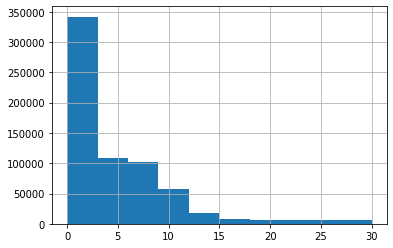

In [271]:
df['speed'].hist()

In [272]:
df['speed'].describe()

count    661064.000000
mean          4.711225
std           5.547541
min           0.004344
25%           0.526149
50%           2.731577
75%           7.240797
max          29.999916
Name: speed, dtype: float64

## pseudonomysed trip data

In [ ]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf = gdf.to_crs(epsg=25833)

In [ ]:
geometry = [Point(xy) for xy in zip(df.next_lon, df.next_lat)]
gdf_end = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf_end = gdf_end.to_crs(epsg=25833)

In [ ]:
berlin = geopandas.read_file('lor_planungsraeume.geojson')
berlin = berlin.to_crs(epsg=25833)

In [ ]:
# map of accessible bikes
base = berlin.plot(color='white', edgecolor='black', figsize=(20,20))
gdf[(gdf['mode']=='accessible') & (gdf.latitude > 52.3) & (gdf.longitude > 13.0)& (gdf.latitude < 53.7) & (gdf.longitude < 13.7)].plot(ax=base, markersize=0.01, figsize=(20,20))

In [ ]:
# map of startpoints
gdf[(gdf['mode']=='trip')].plot(ax=base, markersize=0.01, figsize=(20,20))

In [ ]:
# map of endpoints
gdf_end[(gdf_end['mode']=='trip')].plot(ax=base, markersize=0.01, figsize=(20,20))

In [ ]:
# map both
start = gdf[(gdf['mode']=='trip')].plot(ax=base, markersize=0.01, figsize=(20,20), color='red')
gdf_end[(gdf_end['mode']=='trip')].plot(ax=start, markersize=0.01, figsize=(20,20))

In [ ]:
# heatmap (?)
import geoplot
ax = geoplot.kdeplot(gdf.head(100),
                     shade=True, shade_lowest=False,
                     clip=boroughs.geometry)
geoplot.polyplot(boroughs, ax=base)

#### How many bikes are in use at what point in time (weekday)?

In [4]:
# hour of day
df['hour_of_day'] = df.timestamp.apply(lambda x: x.time().hour)

In [5]:
# day of week
df['day_of_week'] = df.timestamp.apply(lambda x: x.weekday())

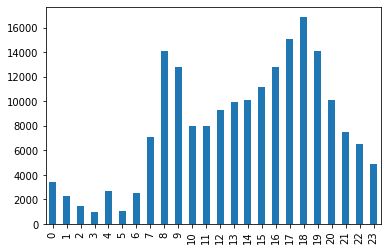

In [289]:
df[(df.providerId == 1) & (df.distance > 300)].dhour.value_counts().sort_index().plot(kind='bar')

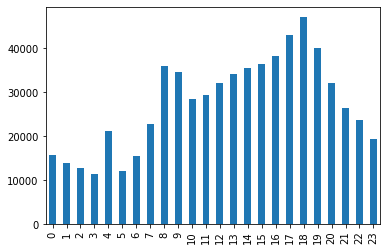

In [251]:
df[df['mode'] == 'trip'].dhour.value_counts().sort_index().plot(kind='bar')

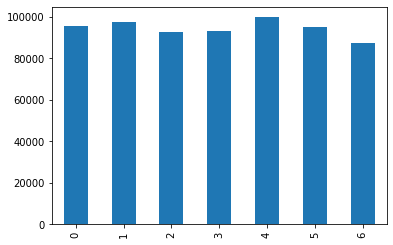

In [320]:
df[df['mode'] == 'trip'].dweek.value_counts().sort_index().plot(kind='bar')

In [ ]:
# see whole time on hourly / daily basis

In [298]:
df.loc[:,'hourly_starttime'] = df.timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 60)))

In [299]:
df[df['mode']=='trip'].hourly_starttime.describe()

count                 2122449
unique                   2405
top       2019-03-28 09:00:00
freq                     2262
first     2019-03-27 18:00:00
last      2019-07-09 19:00:00
Name: hourly_starttime, dtype: object

#### How many rides are there per day?

#### How long is the average ride (time and length)? How fast?

## Geoanalysis 

In [ ]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [ ]:
geometry = [Point(xy) for xy in zip(df.next_lon, df.next_lat)]
endpoints = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [ ]:
gdf[['geometry']].head(1000).to_file('../../data/small_startpoints.geojson', Driver='GeoJSON')

In [ ]:
gdf_vbb = gpd.read_file('../../data/haltestellen-berlin.geojson')

In [ ]:
gdf_vbb.plot()

In [ ]:
gdf_plr = gpd.read_file('lor_planungsraeume.geojson')

In [ ]:
pointInPolys = sjoin(gdf_data.head(), gdf, how='left')

In [ ]:
gdf_data.intersects(gdf.unary_union)

In [ ]:
gpd.overlay(gdf, gdf_data)

#### Where are most rides? (Bezirk, ...) Heatmap

In [ ]:
ax = geoplot.kdeplot(gdf,
                     shade=True, shade_lowest=False,
                     clip=boroughs.geometry)
geoplot.polyplot(gdf_plr, ax=ax)

In [ ]:
# cross with Planungsräume

gdf.rename(index=str, columns={"spatial_name": "cell_id"}, inplace=True)
gdf[['cell_id', 'geometry']].to_file('planungsraeume.json', driver='GeoJSON')
df = pd.DataFrame(gdf)[['cell_id', 'geometry']]
gdf.set_index('cell_id', inplace=True)
gdf['geometry'].to_file('test2.json', driver='GeoJSON', index='False')
f= open("test.json","w")
f.write(gdf['geometry'].to_json())
f.close()    
test = gdf['geometry'].to_dict()
for key, values in test.items():
    print (key)
test = pd.read_json('test.json', orient='records')

#### What are highly frequented routes? (Are there good bike lanes? Should there be better bike lanes?)

#### Are there "hot spots" for pick up and drop off?

## Include further data

#### Intersect with subway stops

#### weather data

#### nextbike stations: with and without docking station: how many rides start from / end at a docking station